In [1]:
import pandas as pd
import xarray as xr

import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, mapping
import cartopy.feature as cfeat
import cartopy.crs as ccrs
import regionmask
import xesmf as xe

import sys
sys.path.append('../')
import utils
import plotting

import math


Bad key "text.kerning_factor" on line 4 in
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Using raster = 4 to get the 2015 GWP population density

## Import Pollution Dataset

In [2]:
#### import our pollution datasets ####
poll_ds = xr.open_zarr("./data/nonuc_normal_GC.zarr/")



## Import Population Density and Land Area Datasets

In [3]:
#### import our dataset for population density ####
ds = xr.open_dataset("/net/fs11/d0/emfreese/population_data/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_adjusted_rev11_2pt5_min.nc")
pop_ds = ds.sel(raster = 4) #density in persons / sq km
pop_ds = pop_ds.rename({'latitude':'lat', 'longitude':'lon'})

pop_ds = pop_ds.assign_coords(coords = {'lat':pop_ds['lat']}) #fix the lat
pop_ds = pop_ds.fillna(0) 
pop_ds = pop_ds.rename({'UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes':'pop_density'})

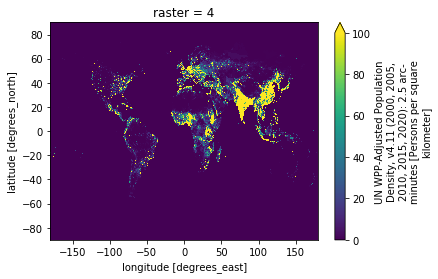

In [4]:
pop_ds['pop_density'].plot.imshow(vmax = 100)

In [5]:
#### import our dataset for land area ####
ds = xr.open_dataset("/net/fs11/d0/emfreese/population_data/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_adjusted_rev11_2pt5_min.nc")
land_ds = ds.sel(raster = 9) #density in persons / sq km
land_ds = land_ds.rename({'latitude':'lat', 'longitude':'lon'})

land_ds = land_ds.assign_coords(coords = {'lat':land_ds['lat']}) #fix the lat
land_ds = land_ds.fillna(0) 
land_ds = land_ds.rename({'UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes':'land_area'})

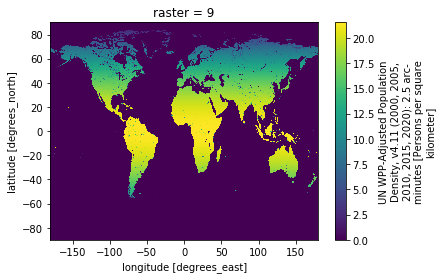

In [6]:
land_ds['land_area'].plot.imshow()

## Merge Land and Population Datasets, Calculate Total Area

In [7]:
#### merge our pop and land area datasets ####
land_pop_ds = xr.merge([pop_ds, land_ds], compat='override')

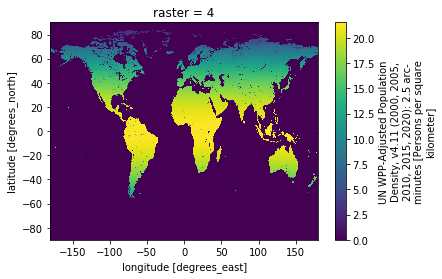

In [8]:
land_pop_ds['land_area'].plot.imshow()

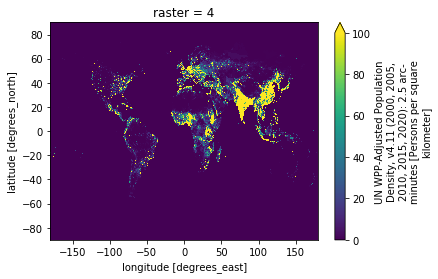

In [9]:
land_pop_ds['pop_density'].plot.imshow(vmax = 100)

In [10]:
#### create lat and lon bounds ####
lonb = land_pop_ds['lon'].values + (land_pop_ds['lon'][0]-land_pop_ds['lon'][1]).values/2
lonb = np.append(lonb, (lonb[-1] - (land_pop_ds['lon'][0]-land_pop_ds['lon'][1]).values))

latb = land_pop_ds['lat'].values + (land_pop_ds['lat'][0]-land_pop_ds['lat'][1]).values/2
latb = np.append(latb, (latb[-1] - (land_pop_ds['lat'][0]-land_pop_ds['lat'][1]).values))

land_pop_ds['lon_b'] = lonb
land_pop_ds['lat_b'] = latb

In [11]:
#### function to find area of a grid cell from lat/lon ####
def find_area(ds, R = 6378.1):
    """ ds is the dataset, i is the number of longitudes to assess, j is the number of latitudes, and R is the radius of the earth in km. 
    Must have the ds['lat'] in descending order (90...-90)
    Returns Area of Grid cell in km"""
    
    dy = (ds['lat_b']- ds['lat_b'].roll({'lat_b':-1}, roll_coords = False))[:-1]*2*np.pi*R/360 

    dx1 = (ds['lon_b'].roll({'lon_b':-1}, roll_coords = False) - 
           ds['lon_b'])[:-1]*2*np.pi*R*np.cos(np.deg2rad(ds['lat_b']))
    
    dx2 = (ds['lon_b'].roll({'lon_b':-1}, roll_coords = False) - 
           ds['lon_b'])[:-1]*2*np.pi*R*np.cos(np.deg2rad(ds['lat_b'].roll({'lat_b':-1}, roll_coords = False)[:-1]))
    
    A = .5*(dx1+dx2)*dy
    
    #### assign new lat and lon coords based on the center of the grid box instead of edges ####
    A = A.assign_coords(lon_b = ds.lon.values,
                    lat_b = ds.lat.values)
    A = A.rename({'lon_b':'lon','lat_b':'lat'})

    A = A.transpose()
    
    return(A)

In [12]:
#### find the area of our original grid cells ####
A = find_area(land_pop_ds)



In [13]:
#### merge to create a new ds with all of our original land and population data ####
orig_ds = xr.merge([land_pop_ds, A.to_dataset(name = 'orig_total_area')])

orig_ds['land_area_ratio'] = orig_ds['land_area']/orig_ds['orig_total_area']
orig_ds['orig_pop_count'] = orig_ds['pop_density']* orig_ds['land_area']


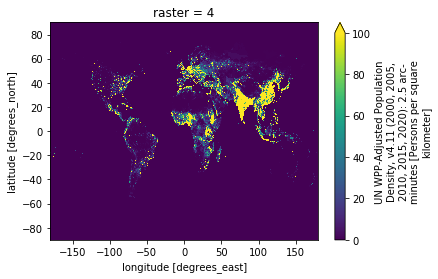

In [14]:
orig_ds['pop_density'].plot.imshow(vmax = 100)

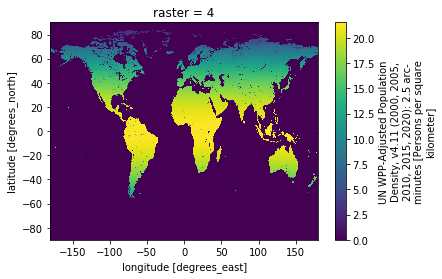

In [15]:
orig_ds['land_area'].plot.imshow()

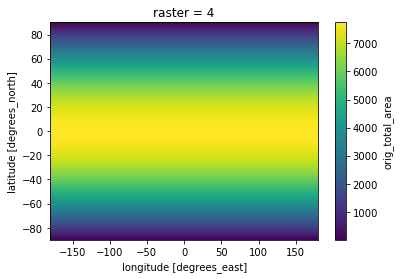

In [16]:
orig_ds['orig_total_area'].plot.imshow()

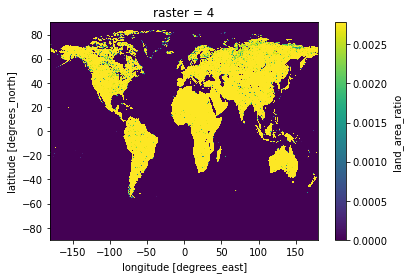

In [17]:
orig_ds['land_area_ratio'].plot.imshow()

## Regrid our dataset

In [18]:
def make_2d_grid(lon_b1, lon_b2, lon_step, lat_b1, lat_b2, lat_step):
    lon_bounds = np.arange(lon_b1, lon_b2+lon_step, lon_step)
    lon_centers = (lon_bounds[:-1] + lon_bounds[1:])/2
    
    lat_bounds = np.arange(lat_b1, lat_b2+lat_step, lat_step)[::-1]
    lat_centers = (lat_bounds[:-1] + lat_bounds[1:])/2
    
    ds = xr.Dataset({'lat': (['lat'], lat_centers),
                     'lon': (['lon'], lon_centers),
                     'lat_b': (['lat_b'], lat_bounds),
                     'lon_b': (['lon_b'], lon_bounds),
                    }
                   )
    return(ds)

In [19]:
#make a ds with grid for output and grid for input 
lat_dif = .5 
lon_dif = .625
ds_out = make_2d_grid(-180, 180, lon_dif, 90, -90, -lat_dif) #grid that we want to regrid to
ds_in = make_2d_grid(-180, 180, .041666667, -90, 90, .041666667) #same as the grid for orig_ds

In [20]:
#create regridder (reusing weights)
regridder = xe.Regridder(ds_in, ds_out, 'conservative', reuse_weights = True)
regridder  # print basic regridder information.

#regrid according to our ds_out grid
regrid_ds = regridder(orig_ds)

#update the latb and lonb so that they match the ds_out values
regrid_ds['lon_b'] = ds_out['lon_b']
regrid_ds['lat_b'] = ds_out['lat_b']

regrid_ds #look at our regridded dataset

/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/xesmf/backend.py:52: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn("Latitude is outside of [-90, 90]")


Reuse existing file: conservative_4320x8640_360x576.nc
using dimensions ('lat', 'lon') from data variable pop_density as the horizontal dimensions for this dataset.


/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


<xarray.Dataset>
Dimensions:          (lat: 360, lat_b: 361, lon: 576, lon_b: 577)
Coordinates:
    raster           int32 4
  * lon_b            (lon_b) float64 -180.0 -179.4 -178.8 ... 178.8 179.4 180.0
  * lat_b            (lat_b) float64 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * lon              (lon) float64 -179.7 -179.1 -178.4 ... 178.4 179.1 179.7
  * lat              (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
Data variables:
    pop_density      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    land_area        (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    orig_total_area  (lat, lon) float64 44.98 44.98 44.98 ... 44.98 44.98 44.98
    land_area_ratio  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    orig_pop_count   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  conservative

In [21]:
#### find the area of our original grid cells ####
A = find_area(regrid_ds)

Area_ds = A.to_dataset(name = 'regrid_total_area')
Area_ds = Area_ds*-1

regrid_area_ds = xr.merge([regrid_ds, Area_ds])
regrid_area_ds = regrid_area_ds.drop(['orig_pop_count', 'land_area', 'orig_total_area'])

In [22]:
#### create new variables in regridded ds ####

regrid_area_ds['regrid_land_area'] = regrid_area_ds['land_area_ratio'] * regrid_area_ds['regrid_total_area'] 

regrid_area_ds['regrid_pop_count'] = regrid_area_ds['regrid_land_area'] * regrid_area_ds['pop_density']

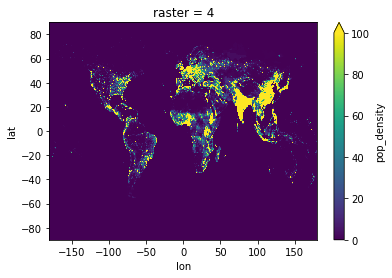

In [23]:
regrid_area_ds['pop_density'].plot.imshow(vmax = 100)

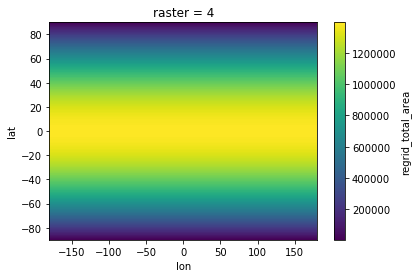

In [24]:
regrid_area_ds['regrid_total_area'].plot.imshow()

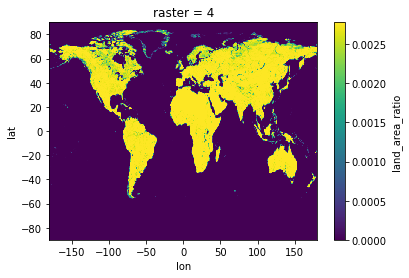

In [25]:
regrid_area_ds['land_area_ratio'].plot.imshow()

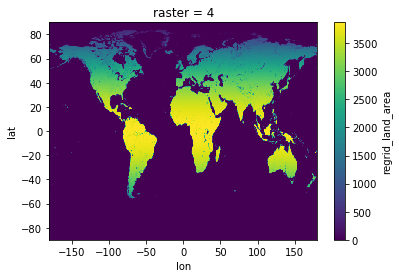

In [26]:
regrid_area_ds['regrid_land_area'].plot.imshow()

In [27]:
#### check that we still have ~7 billion population ####
print(regrid_area_ds['regrid_pop_count'].sum(), orig_ds['orig_pop_count'].sum())

<xarray.DataArray 'regrid_pop_count' ()>
array(7.008563e+09)
Coordinates:
    raster   int32 4 <xarray.DataArray 'orig_pop_count' ()>
array(7.349324e+09, dtype=float32)
Coordinates:
    raster   int32 4


## Mask our data to just the United States

In [28]:
#### create a mask ####
states = regionmask.defined_regions.natural_earth.us_states_50
lon = np.arange(230, 300, .25)
lat = np.arange(50, 24, -.125)
mask = states.mask(regrid_area_ds, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask) & (mask != 0.) & (mask != 11) 

#### mask our population dataset ####
US_land_pop_ds = regrid_area_ds.where(contiguous_mask)

#### mask our pollution dataset ####
US_poll_ds = poll_ds.where(contiguous_mask)

total US population 294193664.8137231


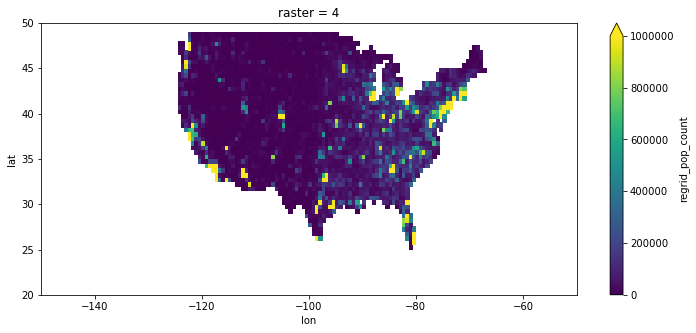

In [29]:
US_land_pop_ds['regrid_pop_count'].plot(figsize = (12,5), vmax = 1000000)
plt.xlim(-150,-50)
plt.ylim(20,50)
print('total US population', US_land_pop_ds['regrid_pop_count'].sum().values)

In [30]:
ds = xr.merge([US_land_pop_ds.interp_like(poll_ds), poll_ds])

# CRF From Vohra et. al 2021

## PM

In [168]:
#beta from Vodonos et al. 2018
beta_orig_df = pd.read_csv('data/CRF_Vodonos_data.csv', names = ['PM25','beta'])
zero_row = pd.DataFrame({'beta':beta_orig_df['beta'][0], 'PM25':0}, index = {0})
β_ds = xr.Dataset.from_dataframe(pd.concat([zero_row, beta_orig_df]).set_index('PM25'))
#interpolate beta onto an even grid
β_ds = β_ds.interp(PM25 = np.arange(0,70,.0001), method = 'linear')
β_ds['Δx'] = β_ds['PM25'].diff(dim = 'PM25')
#convert percent
β_ds['beta'] /= 100.
#mortality data from IHME GBD 2017
obs_mortality = pd.read_csv('../../health_data/global_burden_disease_2017_data/IHME-GBD_2017_DATA-2c4a32b7-1.csv')
obs_mortality = obs_mortality.drop([1,2,3,4,5])

In [169]:
def β_mean_(x0, x1):
    if (x0==x1):
        return β_ds['beta'].sel(PM25 = x0, method = 'nearest')
    if np.isnan(x0) | np.isnan(x1):
        return(np.nan)
    if x1>x0:
        return((1/(x1-x0))*np.sum((β_ds['beta']*β_ds['Δx']).sel(PM25 = slice(x0,x1))))
    if x0>x1:
        return((1/(x0-x1))*np.sum((β_ds['beta']*β_ds['Δx']).sel(PM25 = slice(x1,x0))))

In [170]:
def β_mean(x0, x1):
    return xr.apply_ufunc(
        β_mean_,
        x0,
        x1,
        input_core_dims=[[],[]],  # list with one entry per arg
        output_dtypes=[float],
        vectorize=True
    )

In [171]:
def AF(x0, x1):
    return(np.exp(ds['βm']*(x1 - x0))-1)/np.exp(ds['βm']*(x1 - x0))

In [172]:
x0 = ds["PM25"].sel(model_name = 'normal_model').mean(dim = 'time').compute()
x1 = ds["PM25"].sel(model_name = 'nonuc_model').mean(dim = 'time').compute()
ds['βm'] = β_mean(x0, x1) #calculate the beta for each grid box
ds['AF'] =  AF(x0, x1) #calculate the attributable fraction for each grid box
mortality0 = obs_mortality['val']/ds['regrid_pop_count'].sum().values #calculate our initial mortality rate
ds['Δmortality'] = ds['AF']*ds['regrid_pop_count']*mortality0.values #calculate our change in mortality

Total Increase in Mortalities 9832.055410130937


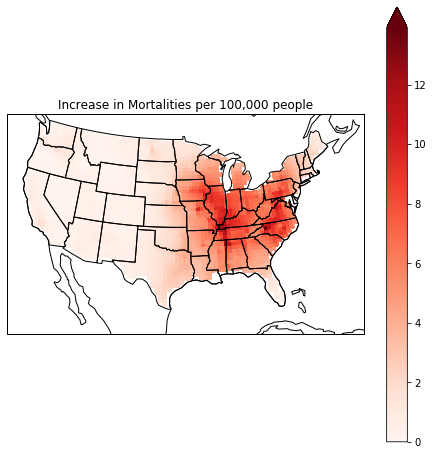

In [175]:
fig, ax = plt.subplots(figsize = [8,8], subplot_kw={'projection':ccrs.LambertConformal()})
(1e5*ds['Δmortality']/ds['regrid_pop_count']).plot(ax = ax, cmap = 'Reds',transform=ccrs.PlateCarree(),extend = 'max')
plt.title('Increase in Mortalities per 100,000 people')
ax.add_feature(cfeat.STATES)
ax.coastlines()
ax.set_extent([-120,-70,20,50])
print('Total Increase in Mortalities ' + str(ds['Δmortality'].sum().values))


# CRF From Turner 2016

## Ozone
(hazard ratio [HR] per 10 ppb, 1.02; 95% confidence interval [CI], 1.01–1.04) from Turner 2016

In [153]:
#bootstrap function    
def draw_bs(x, size):
    #Perform pairs bootstrap for linear regression

    # Set up array of indices to sample from: inds
    inds = np.arange(0,len(x))

    # Generate replicates
    bs_inds = np.random.choice(inds, size=size)
    bs_val= x[bs_inds]
        
    return bs_val

In [156]:
delta_chi = 10 #ppb
RR = 1.02 #
β = np.log(RR)/delta_chi
CI_min = 1.01
sd = (RR-CI_min)/2
draws = 100000
#create normal distribution around our beta
β_normal_dist = np.random.normal(β, sd, draws)
#draw 1000 from this and add to the dataset
ds['βm'] = xr.DataArray(draw_bs(β_normal_dist, size=draws), dims = ['vals'], coords = {'vals':np.arange(0, draws)})

In [157]:
x0 = ds["O3"].sel(model_name = 'normal_model').sel(time = ds.time.dt.month.isin([6,7,8])).groupby('time.dayofyear').max().mean(dim = 'dayofyear').compute()
x1 = ds["O3"].sel(model_name = 'nonuc_model').sel(time = ds.time.dt.month.isin([6,7,8])).groupby('time.dayofyear').max().mean(dim = 'dayofyear').compute()
ds['AF'] =  AF(x0, x1) #calculate the attributable fraction for each grid box
mortality0 = obs_mortality['val']/ds['regrid_pop_count'].sum().values #calculate our initial mortality rate
ds['Δmortality'] = ds['AF']*ds['regrid_pop_count']*mortality0.values #calculate our change in mortality

/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Total Decrease in Mortalities -1229.7323843281802


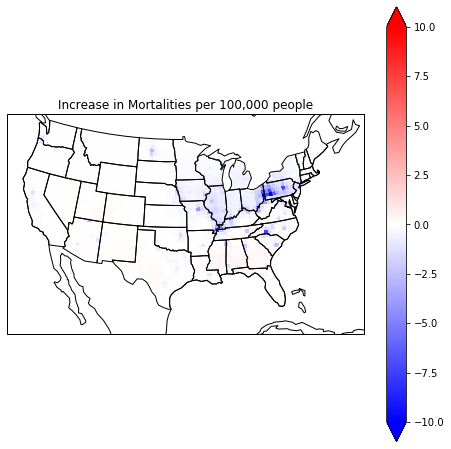

In [159]:
fig, ax = plt.subplots(figsize = [8,8], subplot_kw={'projection':ccrs.LambertConformal()})
(1e5*ds['Δmortality'].mean(dim = 'vals')/ds['regrid_pop_count']).plot(ax = ax, cmap = 'bwr',transform=ccrs.PlateCarree(),vmin = -10, vmax = 10, extend = 'both')
plt.title('Increase in Mortalities per 100,000 people')
ax.add_feature(cfeat.STATES)
ax.coastlines()
ax.set_extent([-120,-70,20,50])
print('Total Decrease in Mortalities ' + str(ds['Δmortality'].mean(dim = 'vals').sum().values))